In [264]:
import numpy as np
import scipy as sp
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate as tab
import dython as dt
from tabulate import tabulate
from pandas.plotting import scatter_matrix
from dython.nominal import associations


In [265]:
df = pd.read_csv('XY_train.csv',encoding='latin-1')
df.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,13163,city_16,0.910,NaN,No relevent experience,no_enrollment,High School,NaN,2,NaN,NaN,never,16,1
1,9357,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,6,1000-4999,Pvt Ltd,1,262,0
2,604,city_16,0.910,Male,No relevent experience,NaN,NaN,NaN,3,NaN,NaN,never,24,0
3,19033,city_16,0.910,Male,No relevent experience,no_enrollment,High School,NaN,3,NaN,NaN,1,35,0
4,4825,city_145,0.555,Male,Has relevent experience,Full time course,Graduate,STEM,4,NaN,NaN,1,43,1


## Pre-processing
### Dealing with missing values
#### "gender", "company_size", "company_type" - I added an unknown category
#### "enrolled_university", "major_discipline", "education_level", "last_new_job" - fillna with the mode value: "no_enrollment", "STEM"

In [266]:
df["gender"] = df["gender"].fillna("unknown")
df["company_size"] = df["company_size"].fillna("unknown")
df["company_type"] = df["company_type"].fillna("unknown")
print(df["enrolled_university"].mode())
df["enrolled_university"] = df["enrolled_university"].fillna("no_enrollment")
print(df["major_discipline"].mode())
df["major_discipline"] = df["major_discipline"].fillna("STEM")
print(df["last_new_job"].mode())
df["last_new_job"] = df["last_new_job"].fillna("1")
print(df["education_level"].mode())
df["education_level"] = df["education_level"].fillna("Graduate")
df.company_size[df.company_size=='àå÷-49' ] = '10-49'
df.company_size[df.company_size=='500-999'] = '500-1K'
df.company_size[df.company_size=='1000-4999'] = '1K-5K'
df.company_size[df.company_size=='5000-9999'] = '5K-10K'
df.company_size[df.company_size=='10000+'] = '10K+'

0    no_enrollment
dtype: object
0    STEM
dtype: object
0    1
dtype: object
0    Graduate
dtype: object


<ipython-input-266-6303dc2c2e78>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.company_size[df.company_size=='àå÷-49' ] = '10-49'
<ipython-input-266-6303dc2c2e78>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.company_size[df.company_size=='500-999'] = '500-1K'
<ipython-input-266-6303dc2c2e78>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.company_size[df.company_size=='1000-4999'] = '1K-5K'
<ipython-input-266-6303dc

### "experience" - cut to 4 level ("low", "low-middle", "middle-high", "high")¶

In [267]:
print(df["experience"].unique())
df["experience"] = df["experience"].replace("<1","1")
df["experience"] = df["experience"].replace(">20","20")
df["experience"] = pd.to_numeric(df["experience"])
print(df["experience"].unique())
print(df["experience"].mode())
df["experience"] = df["experience"].fillna(20)
print(df["experience"].value_counts())
bins = [0,5,9,15,20]
labels = ["low", "low-middle", "middle-high", "high"]
df["experience"] = pd.cut(df["experience"], bins= bins, labels= labels)
print(df["experience"].value_counts())

## experience
df["experience"] = df["experience"].replace("low",0)
df["experience"] = df["experience"].replace("low-middle",1)
df["experience"] = df["experience"].replace("middle-high",2)
df["experience"] = df["experience"].replace("high",3)

df.experience= df.experience.astype(int)

['2' '6' '3' '4' '>20' '13' '19' '10' '1' '5' '7' '20' '14' '16' '12' '15'
 '8' '<1' '17' '9' '11' '18' nan]
[ 2.  6.  3.  4. 20. 13. 19. 10.  1.  5.  7. 14. 16. 12. 15.  8. 17.  9.
 11. 18. nan]
0    20.0
dtype: float64
20.0    2783
5.0     1161
4.0     1097
3.0     1084
6.0      979
2.0      889
1.0      841
7.0      825
9.0      804
10.0     789
8.0      636
15.0     572
11.0     525
14.0     478
16.0     403
12.0     393
13.0     313
17.0     282
19.0     249
18.0     223
Name: experience, dtype: int64
low            5072
high           3940
low-middle     3244
middle-high    3070
Name: experience, dtype: int64


# Feature Representation

### Binary Variable

In [268]:
df.relevent_experience[df.relevent_experience=='No relevent experience'] = 0
df.relevent_experience[df.relevent_experience=='Has relevent experience'] = 1
df.relevent_experience = df.relevent_experience.astype(int)

<ipython-input-268-3454120d1338>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.relevent_experience[df.relevent_experience=='No relevent experience'] = 0
<ipython-input-268-3454120d1338>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.relevent_experience[df.relevent_experience=='Has relevent experience'] = 1


### LabelEncoder - Order is important

In [269]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [270]:
cols = ["education_level", "experience", "last_new_job", "company_size", "enrolled_university"]

## education_level
encoder= ce.OrdinalEncoder(cols=['education_level'],return_df=True,
                           mapping=[{'col':'education_level',
'mapping':{'Primary':0,'High school':1,'Graduate':2,'Masters':3,'Phd':4,}}])
df['education_level'] = encoder.fit_transform(df['education_level'])
df["education_level"] = df["education_level"].replace(-1,1)

## enrolled_university
encoder= ce.OrdinalEncoder(cols=['enrolled_university'],return_df=True,
                           mapping=[{'col':'enrolled_university',
'mapping':{'no_enrollment':0,'Part time course':1,'Full time course':2,}}])
df['enrolled_university'] = encoder.fit_transform(df['enrolled_university'])

## last_new_job
encoder= ce.OrdinalEncoder(cols=['last_new_job'],return_df=True,
                           mapping=[{'col':'last_new_job',
'mapping':{'never':0,'1':1,'2':2,'3':3,'4':4,'>4':5}}])
df['last_new_job'] = encoder.fit_transform(df['last_new_job'])

## company_size
encoder= ce.OrdinalEncoder(cols=['company_size'],return_df=True,
                           mapping=[{'col':'company_size',
'mapping':{'unknown':0,'<10':1,'10-49':2,'50-99':3,'100-500':4,'500-1K':5,'1K-5K':6,'5K-10K':7,'10K+':8}}])
df['company_size'] = encoder.fit_transform(df['company_size'])


## Get Dummies - Order is Not important

In [271]:
## gender
encoder=ce.OneHotEncoder(cols='gender',return_df=True,use_cat_names=True)
df_encoded = encoder.fit_transform(df.gender)
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(columns="gender")
df.head(10)

## major_discipline
encoder=ce.OneHotEncoder(cols='major_discipline',return_df=True,use_cat_names=True)
df_encoded = encoder.fit_transform(df.major_discipline)
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(columns="major_discipline")

## company_type
encoder=ce.OneHotEncoder(cols='company_type',return_df=True,use_cat_names=True)
df_encoded = encoder.fit_transform(df.company_type)
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(columns="company_type")

In [272]:
df= df.drop(columns =["enrollee_id", "city"])
df.head()

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,last_new_job,training_hours,target,gender_unknown,...,major_discipline_Humanities,major_discipline_No Major,major_discipline_Business Degree,company_type_unknown,company_type_Pvt Ltd,company_type_Public Sector,company_type_NGO,company_type_Other,company_type_Early Stage Startup,company_type_Funded Startup
0,0.910,0,0,1.0,0,0,0,16,1,1,...,0,0,0,1,0,0,0,0,0,0
1,0.897,1,0,3.0,1,6,1,262,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.910,0,0,2.0,0,0,0,24,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0.910,0,0,1.0,0,0,1,35,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.555,1,2,2.0,0,0,1,43,1,0,...,0,0,0,1,0,0,0,0,0,0


## Feature Representation

#### Standardization of  continuous Variables

In [273]:
from sklearn.preprocessing import StandardScaler

features = ['city_development_index','training_hours']
df[features] = StandardScaler().fit_transform(df[features])
df_x = df.drop(columns =["target"])
df_y = df["target"]

## No feature selection

In [274]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import cross_val_score


In [275]:
from sklearn.model_selection import train_test_split # Import train_test_split function
# Split dataset into training set and test set

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42) # 80% training and 20% test

In [276]:
# How Train and Test are splitted

print("Train\n-----------\n", pd.value_counts(y_train)/y_train.shape[0])
print("\nTest\n-----------\n", pd.value_counts(y_test)/y_test.shape[0])

Train
-----------
 0    0.749429
1    0.250571
Name: target, dtype: float64

Test
-----------
 0    0.754403
1    0.245597
Name: target, dtype: float64


In [277]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Training the Baseline model
# random_state=77,criterion='entropy'
model = DecisionTreeClassifier(random_state=77)
model.fit(X_train, y_train)
print("Roc_Auc_Score:",roc_auc_score(y_test, model.predict(X_test)))

Roc_Auc_Score: 0.6113617299070041


In [278]:
from sklearn.model_selection import GridSearchCV

parameters_grid = {'max_depth': np.arange(1, 20, 1),
                   'criterion': ['entropy', 'gini'],
                   'max_features': ['auto', 'sqrt', 'log2', None],
                   'min_samples_split': np.arange(2,20,2),
                   
             }

GS = GridSearchCV(estimator= model,
                  scoring = 'roc_auc',
                  param_grid=parameters_grid,
                  cv = 10,
                  return_train_score = True,
                  refit = 'roc_auc')
GS.fit(X_train, y_train)
best_model = GS.best_estimator_
# print (best_model.best_score_, best_model.best_params_) 
prediction = best_model.predict(X_test)
print("Best Roc_Auc_Score on Training Set:",round(GS.best_score_, 3))
print("Best Parameters: " ,GS.best_params_)
print("Roc_Auc_Score on Test Set:", round(roc_auc_score(y_test, prediction),3))

Best Roc_Auc_Score on Training Set: 0.797
Best Parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_split': 18, 'splitter': 'best'}
Roc_Auc_Score on Test Set: 0.7


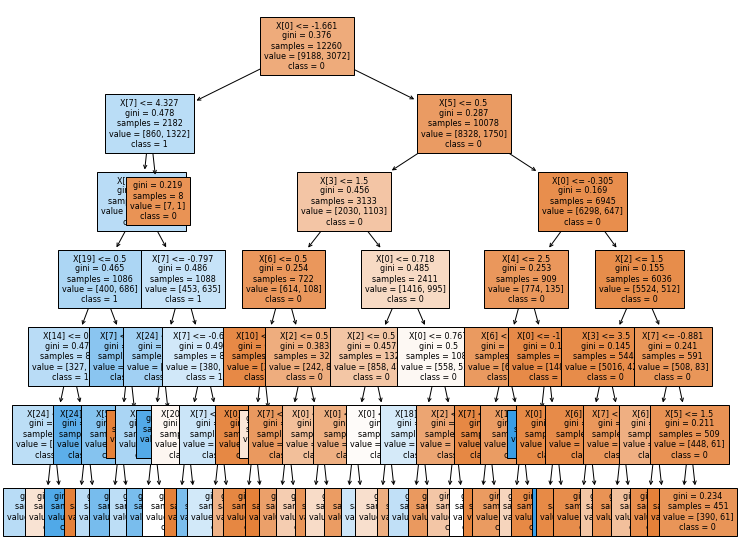

In [279]:
plt.figure(figsize=(12, 10))
plot_tree(best_model, filled=True, class_names=['0', '1'],fontsize = 8)
plt.show()

In [280]:
# plt.figure(figsize=(12, 10))
# plot_tree(model, filled=True, class_names=True)
# plt.show()